In [1]:
import os
import keras
import random
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, InceptionV3, EfficientNetB0, ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

base_dir = os.getcwd()
print(base_dir)

2024-06-08 06:36:00.784166: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-08 06:36:00.784265: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-08 06:36:00.910212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/working


In [2]:
!pip install -q roboflow

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Reason for being yanked: deprecated, use 4.8.0.76
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
jupyterlab 4.2.1 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.1.0 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
osmnx 1.9.3 requires shapely>=2.0, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tensorflow 2.15.0 requires keras<

In [3]:
%cd {base_dir}/

/kaggle/working


In [4]:
import roboflow
from roboflow import Roboflow

roboflow. login()

rf = roboflow. Roboflow()
project = rf.workspace("ltn").project("acne-ovkue")
version = project.version(1)
dataset = version.download("multiclass")

visit https://app.roboflow.com/auth-cli to get your authentication token.


Paste the authentication token here:  ····································


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to acne-1 in multiclass:: 100%|██████████| 8686/8686 [00:01<00:00, 5714.80it/s]


In [5]:
# Paths to the directories
train_directory = 'acne-1/train'
valid_directory = 'acne-1/valid'
test_directory = 'acne-1/test'

In [6]:
# Read metadata
train_df = pd.read_csv(train_directory + '/_classes.csv')
# train_df = train_df.drop(train_df[(train_df[' Acne'] == 1) & (train_df[[' Blackhead', ' Conglobata', ' Crystanlline', ' Cystic', ' Flat_wart', ' Folliculitis', ' Keloid', ' Milium', ' Papular', ' Purulent', ' Scars', ' Sebo-crystan-conglo', ' Syringoma', ' Whitehead']] == 0).all(axis=1)].index[:3000], inplace=False)
# train_df.reset_index(drop=True, inplace=True)  # Reset the index after dropping rows
valid_df = pd.read_csv(valid_directory + '/_classes.csv')
test_df = pd.read_csv(test_directory + '/_classes.csv')

In [7]:
# Get the frequency of each class in the training dataset and sort in descending order
print("Training dataset class frequency:")
print(train_df.iloc[:, 1:].sum(axis=0).sort_values(ascending=False))

# Get the frequency of each class in the validation dataset and sort in descending order
print("Validation dataset class frequency:")
print(valid_df.iloc[:, 1:].sum(axis=0).sort_values(ascending=False))

# Get the frequency of each class in the testing dataset and sort in descending order
print("Testing dataset class frequency:")
print(test_df.iloc[:, 1:].sum(axis=0).sort_values(ascending=False))

Training dataset class frequency:
Pimples         6183
papular         4578
purulent        3989
blackhead       2881
cystic          1524
milium           855
keloid           646
folliculitis     583
crystanlline     447
conglobata        58
dtype: int64
Validation dataset class frequency:
Pimples         480
papular         396
purulent        323
blackhead       251
cystic          125
milium           71
keloid           63
folliculitis     56
crystanlline     48
conglobata        2
dtype: int64
Testing dataset class frequency:
Pimples         182
papular         130
purulent        119
blackhead        65
cystic           37
milium           22
keloid           20
folliculitis     19
crystanlline     17
conglobata        2
dtype: int64


In [8]:
# Define the image size and batch size
SIZE = 224
BATCH_SIZE = 32

def load_images(df, directory):
    X_dataset = []
    y_dataset = df.drop(['filename'], axis=1).values
    for i in tqdm(range(df.shape[0])):
        # Join the directory and filename to form the full path
        img_path = os.path.join(directory, df['filename'][i])

        if not os.path.isfile(img_path):
            print(f"[Error] File not found: {img_path}")
            continue

        img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
        img = image.img_to_array(img)
        img = img / 255.0
        X_dataset.append(img)

    X_dataset = np.array(X_dataset)
    return X_dataset, y_dataset

In [9]:
# Load images and labels
X_train, y_train = load_images(train_df, train_directory)
X_valid, y_valid = load_images(valid_df, valid_directory)
X_test, y_test = load_images(test_df, test_directory)

100%|██████████| 216/216 [00:00<00:00, 355.19it/s]


In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [11]:
train_df.shape[1] - 1

10

In [12]:
# base_model = MobileNetV2(weights='imagenet', 
#                          include_top=False, 
#                          input_shape=(224, 224, 3))
# top_model = Sequential()
# top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
# top_model.add(Dense(32, activation='relu'))
# top_model.add(Dense(train_df.shape[1] - 1, activation='sigmoid')) 
    
# input_tensor = Input(shape=(224, 224, 3))
# output_tensor = top_model(base_model(input_tensor))
# model = Model(inputs=input_tensor, outputs=output_tensor)

# # Freeze the base model layers
# for layer in base_model.layers:
#     layer.trainable = False
        
# model.compile(optimizer=Adam(learning_rate=0.0001),
#               loss='binary_crossentropy',
#               metrics=['accuracy']) 


In [13]:
from tensorflow.keras.applications import EfficientNetB0

# Define the model with additional Dropout for regularization
base_model= InceptionV3(weights='imagenet', 
                         include_top=False, 
                         input_shape=(224, 224, 3))


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
top_model = Sequential()
top_model.add(Input(shape=base_model.output_shape[1:]))  # Use Input layer to specify the shape
top_model.add(GlobalAveragePooling2D())
top_model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
top_model.add(Dropout(0.4))
top_model.add(Dense(y_train.shape[1], activation='sigmoid'))  # Assuming y_train is your label data

In [15]:
input_tensor = Input(shape=(224, 224, 3))
output_tensor = top_model(base_model(input_tensor))
model = Model(inputs=input_tensor, outputs=output_tensor)

for layer in base_model.layers:
    layer.trainable = False

In [16]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [17]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10)             │     1,054,218 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,857,002 (87.19 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [18]:
# # Callbacks
# lr_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# class CustomCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         if logs.get('accuracy') > 0.85 and logs.get('val_accuracy') > 0.70:
#             print("\nTarget achieved, stopping training...")
#             self.model.stop_training = True
            
# custom_callback = CustomCallback()

# # Calculate steps per epoch and validation steps
# steps_per_epoch = train_generator.n // BATCH_SIZE
# validation_steps = valid_generator.n // BATCH_SIZE

# # Train the model with steps_per_epoch and validation_steps
# history = model.fit(
#     train_generator,
#     epochs=30,
#     validation_data=valid_generator,
#     verbose=1,
#     callbacks=[early_stopping, lr_reduction, custom_callback],
#     steps_per_epoch=steps_per_epoch,
#     validation_steps=validation_steps
# )

# **BORDER**
---------------------------------------------------------

In [19]:
checkpoint = ModelCheckpoint('pt8model.keras', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

In [20]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

callback = LearningRateScheduler(scheduler)

In [21]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=50, 
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint, early_stopping, reduce_lr, callback],
    verbose=1
)

Epoch 1/50


Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.


  2/245 ━━━━━━━━━━━━━━━━━━━━ 21s 87ms/step - accuracy: 0.0938 - loss: 1.5669   

I0000 00:00:1717828695.658832     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717828695.712603     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


160/245 ━━━━━━━━━━━━━━━━━━━━ 34s 401ms/step - accuracy: 0.5837 - loss: 1.2465

W0000 00:00:1717828759.264218     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


245/245 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.6073 - loss: 1.2114

W0000 00:00:1717828791.468348     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717828804.880607     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


245/245 ━━━━━━━━━━━━━━━━━━━━ 137s 452ms/step - accuracy: 0.6075 - loss: 1.2111 - val_accuracy: 0.7753 - val_loss: 1.0081 - learning_rate: 1.0000e-04
Epoch 2/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.7282 - loss: 0.9608 - val_accuracy: 0.7674 - val_loss: 0.8626 - learning_rate: 1.0000e-04
Epoch 3/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 82s 314ms/step - accuracy: 0.7630 - loss: 0.8170 - val_accuracy: 0.7959 - val_loss: 0.7497 - learning_rate: 1.0000e-04
Epoch 4/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 79s 312ms/step - accuracy: 0.7722 - loss: 0.7166 - val_accuracy: 0.7737 - val_loss: 0.6713 - learning_rate: 1.0000e-04
Epoch 5/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 79s 314ms/step - accuracy: 0.7747 - loss: 0.6386 - val_accuracy: 0.8101 - val_loss: 0.6185 - learning_rate: 1.0000e-04
Epoch 6/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 78s 310ms/step - accuracy: 0.7863 - loss: 0.5815 - val_accuracy: 0.7816 - val_loss: 0.5657 - learning_rate: 1.0000e-04
Epoch 7/50
245/245 ━━━━━━━━━━━━━━━━━━━━ 79s 311ms/step -

In [26]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 10)             │     1,054,218 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,965,440 (95.24 MB)

 Trainable params: 1,054,218 (4.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 2,108,438 (8.04 MB)

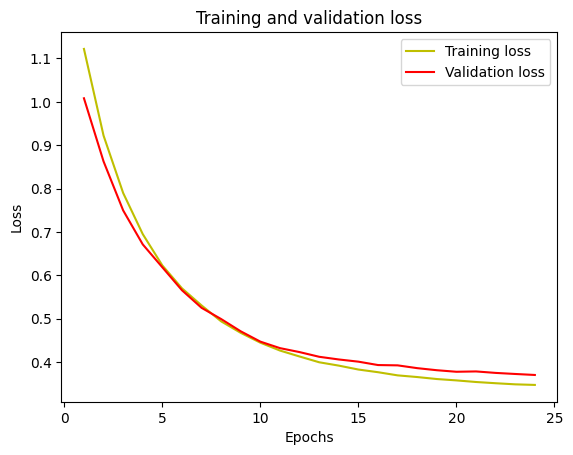

In [27]:
# Plotting the results
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

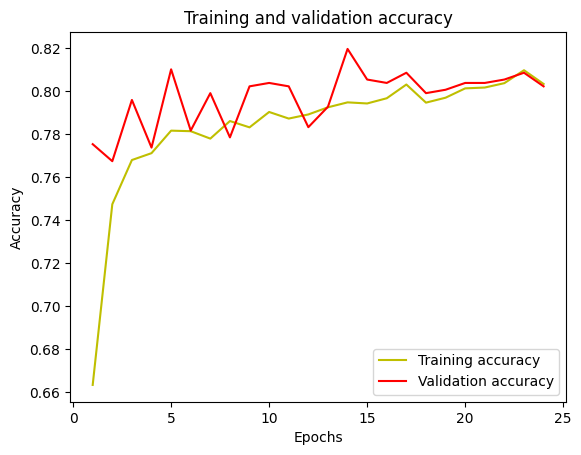

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [30]:
from tensorflow.keras.models import save_model

# Save the model
model.save('/kaggle/working/acne-1/pt7model.keras')

In [31]:
model = tf.keras.models.load_model('/kaggle/working/acne-1/pt7model.keras')

In [33]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.8294 - loss: 0.3953
Test Accuracy: 84.26%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


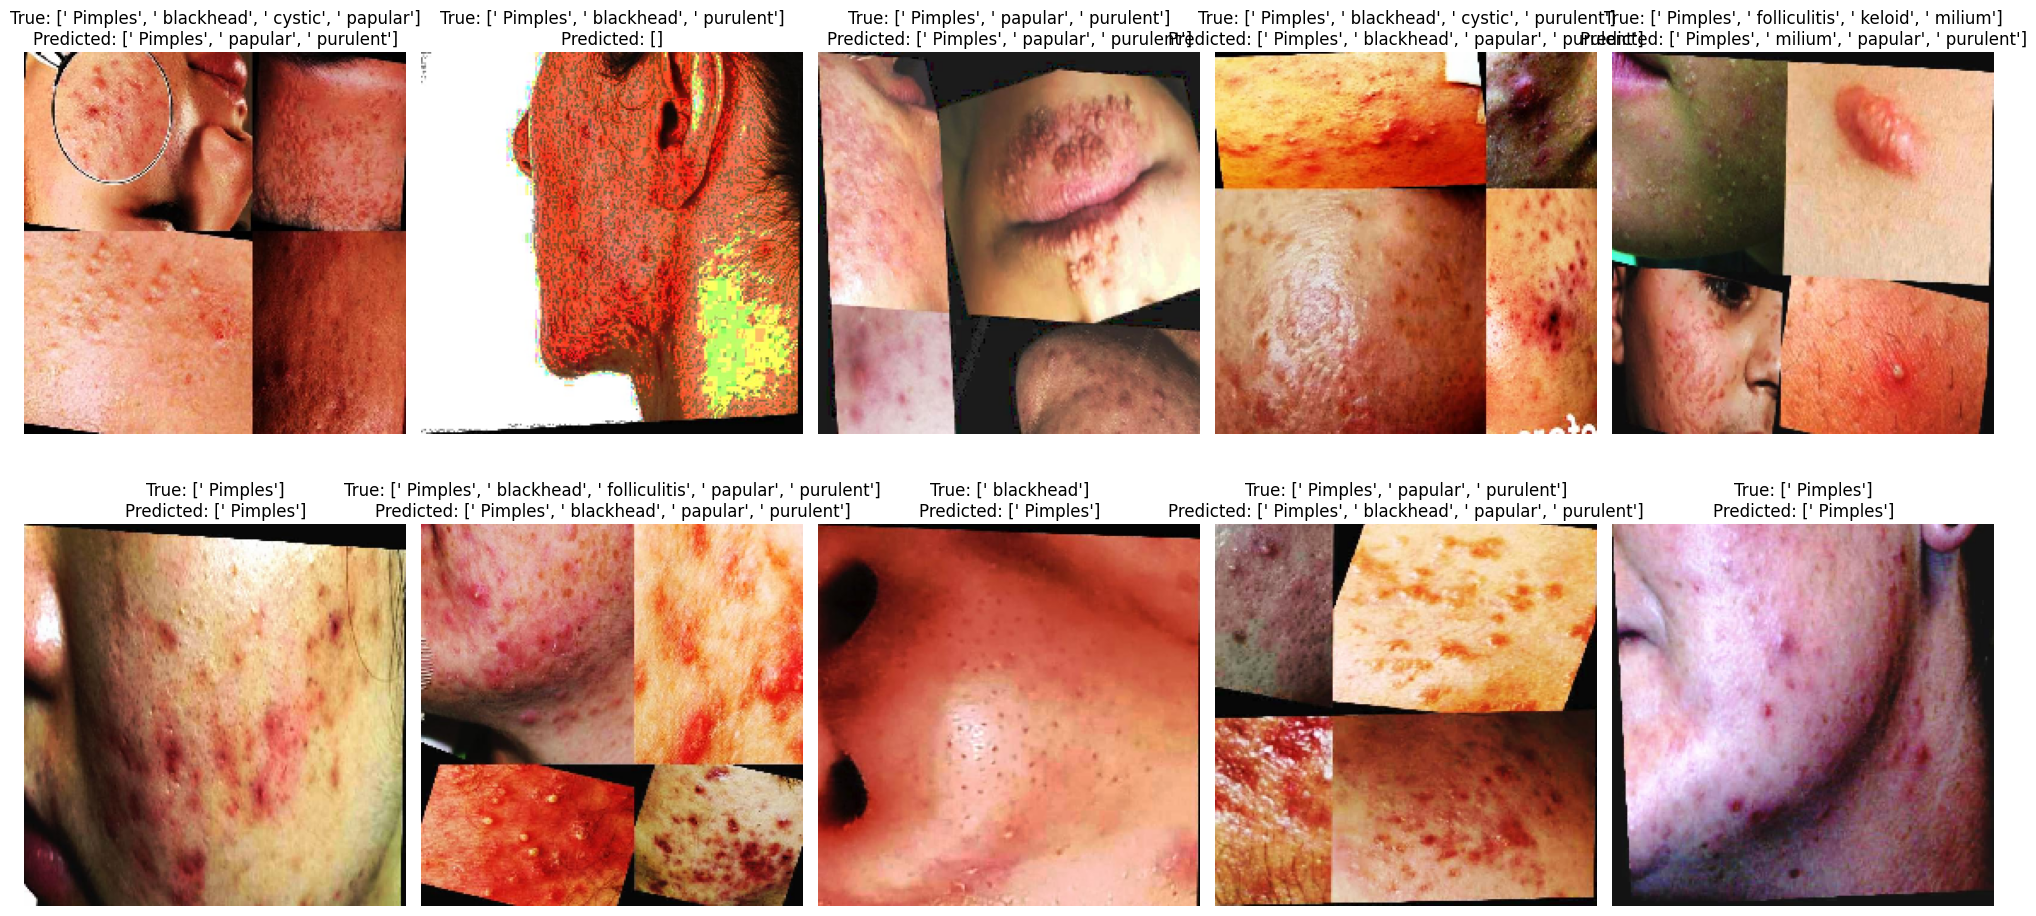

In [36]:
# Define class names
class_names = train_df.columns[1:].tolist()  # Exclude the filename column

def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
    img_array = image.img_to_array(img)
    img_array = tf.keras.applications.inception_v3.preprocess_input(img_array)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to get the true label from the filename
def get_true_label(filename, df):
    row = df[df['filename'] == filename]
    label = row.drop(['filename'], axis=1).values[0]
    return [class_names[i] for i in range(len(label)) if label[i] == 1]

# Function to plot images with true and predicted labels
def plot_images_with_labels(img_paths, true_labels, predicted_labels):
    plt.figure(figsize=(20, 10))
    for i, img_path in enumerate(img_paths):
        img = image.load_img(img_path, target_size=(SIZE, SIZE, 3))
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f'True: {true_labels[i]}\nPredicted: {predicted_labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Test with 10 random images from the test folder
random_imgs = random.sample(os.listdir(test_directory), 10)
img_paths = [os.path.join(test_directory, img) for img in random_imgs]
img_arrays = [load_and_preprocess_image(img_path) for img_path in img_paths]
predictions = [model.predict(img_array) for img_array in img_arrays]

# Get the true and predicted labels
true_labels = [get_true_label(img, test_df) for img in random_imgs]
predicted_labels = [[class_names[i] for i in range(len(prediction[0])) if prediction[0][i] > 0.5] for prediction in predictions]

# Plot the images with true and predicted labels
plot_images_with_labels(img_paths, true_labels, predicted_labels)

In [37]:
model.save('dermoally-model.h5')